In [282]:
# imports 
import pandas as pd
import numpy as np
import scipy.signal as ss
import scraper as sc
import indicators as ind
import analyze_patterns as ap
import datetime as dt
import matplotlib.pyplot as plt

***
# Analyze Patterns

This notebook aims for following goals:
1) Filter and detect critical reversal points in stock price development
2) Analyze stock behaviour before beginning of an uptrend in terms of technical analysis
    1) Determine how certain indicators behave (divergences, lower lows)
    2) Find patterns and determine their probability of success

Result of the analysis over the whole market should be the ability to find and backtest certain patterns and use these pattern to screen for trading opportunities

In [283]:
# scrape for data
# currently only one stock, last 720 days, in the future update for 
stock = sc.stock_daily("MSFT", save=False, delta=dt.timedelta(days=730))

In [284]:
# Goal 1:
# Filter the price data (focus on close) using EMA3
# Find local minimum/maximum as a critical point
filtered_close = ind.ema(stock.data, 3, price="Close")["EMA"].to_numpy()
bollb = ind.bollbands(stock.data, stdn=1)
bollb["dif"] = bollb["upper"] - bollb["lower"]
# determine points of interest
top_points = ss.find_peaks(filtered_close, prominence=bollb["dif"].mean()/2)[0]
bottom_points = ss.find_peaks(-filtered_close, prominence=bollb["dif"].mean()/2)[0]
# create table with points of interest
poi = np.sort(np.concatenate((top_points, bottom_points)))
test = np.repeat(poi[1:], repeats=2)
poi = np.concatenate([[poi[0]], np.repeat(poi[1:], repeats=2), [stock.data.shape[0]-1]])
p1 = poi[::2]
p2 = poi[1::2]
val1 = filtered_close[poi[::2]]
val2 = filtered_close[poi[1::2]]
# create table
reg = pd.DataFrame({"p1":p1, "p2":p2, "val1": val1, "val2": val2})
del p1, p2, val1, val2
reg["length"] = reg["p2"] - reg["p1"]
reg["uptrend"] = reg["val1"] < reg["val2"]
reg["fit"] = np.NaN
for i in reg.index:
    x = np.concatenate([[reg.loc[i,"p1"]], [reg.loc[i,"p2"]]])
    y = np.concatenate([[reg.loc[i,"val1"]], [reg.loc[i,"val2"]]])
    reg.loc[i,"fit"] = np.polyfit(x, y, deg=1)[0]


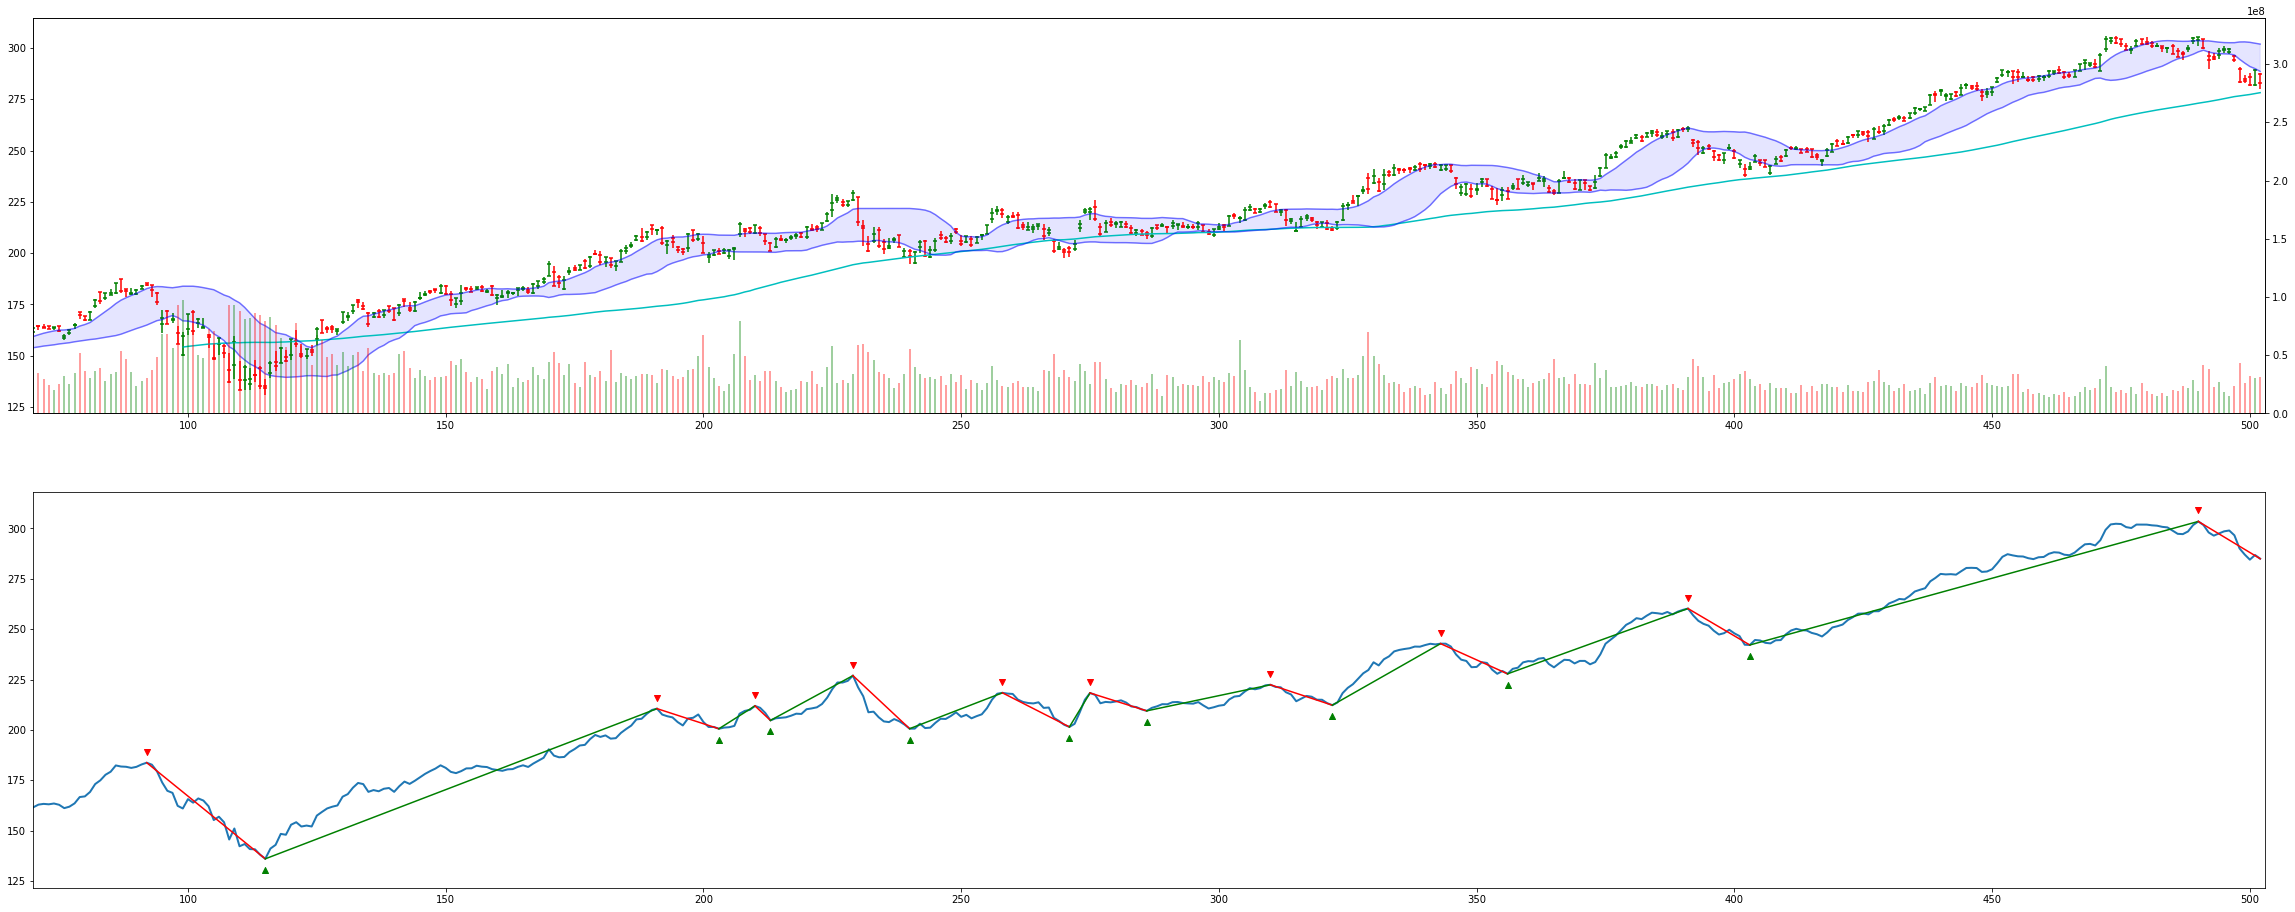

In [285]:
# create plot for the filtered data
fig, ax = plt.subplots(nrows=2, figsize=(40,16))

# plot candlesticks with bollbands and sma100
axy = ax[0].twinx()
ind.plot_candlestick(ax[0], axy, stock)
ax[0].plot(ind.sma(stock.data, 100, price="Close")["SMA"], color="c")
ax[0].plot(bollb["upper"], color="b", alpha=0.5)
ax[0].plot(bollb["lower"], color="b", alpha=0.5)
ax[0].fill_between(np.arange(bollb.shape[0]), bollb["lower"], bollb["upper"], color="b", alpha=0.1)
ax[0].set_xlim([70, stock.data.shape[0]])


# plot filtered data
ax[1].plot(filtered_close, linewidth=2)
ax[1].set_xlim([70, stock.data.shape[0]])
ax[1].scatter(top_points, filtered_close[top_points]+bollb["dif"].mean()/2, color="r", marker="v")
ax[1].scatter(bottom_points, filtered_close[bottom_points]-bollb["dif"].mean()/2, color="g", marker="^")
for i in reg.index:
    if reg.loc[i,"uptrend"] == True:
        ax[1].plot(np.arange(reg.loc[i,"p1"], reg.loc[i,"p2"]+1), reg.loc[i, "fit"]*np.arange(reg.loc[i,"length"]+1) + reg.loc[i,"val1"], color="g")
    else:
        ax[1].plot(np.arange(reg.loc[i,"p1"], reg.loc[i,"p2"]+1), reg.loc[i, "fit"]*np.arange(reg.loc[i,"length"]+1) + reg.loc[i,"val1"], color="r")

